In [33]:
import torch
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Device Configuration

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hyper-parameters


In [64]:
epochs = 10
batch_size = 32
learning_rate = 0.001

Transformation to Tensors of normal range [-1, 1]

In [36]:
#dataset has PILImage images of range[0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

 CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class


In [37]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

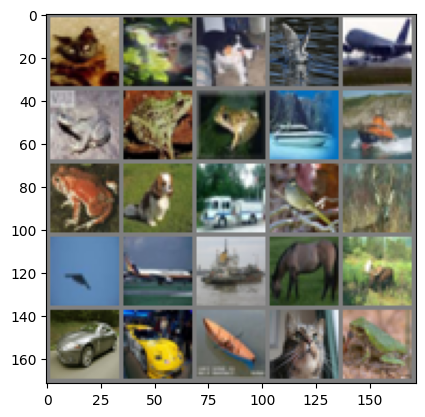

In [39]:
def imshow(imgs):
    imgs = imgs / 2 + 0.5
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

# one batch of random training images
dataiter = iter(train_loader)
batch = next(dataiter)
images, labels = batch[0], batch[1]
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))   # -> N, 32, 30, 30
        x = self.pool(x)            # -> N, 32, 15, 15
        x = F.relu(self.conv2(x))   # -> N, 64, 13, 13
        x = self.pool(x)            # -> N, 64, 6, 6
        x = F.relu(self.conv3(x))   # -> N, 64, 4, 4
        x = torch.flatten(x, 1)     # -> N, 1024
        x = F.relu(self.fc1(x))     # -> N, 64
        x = self.fc2(x)             # -> N, 10
        return x

In [51]:
model = ConvNet().to(device)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [66]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    valid_losses = []


    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        valid_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, valid_losses


Training Model

In [67]:
train_loss, valid_loss = train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch [1/10], Train Loss: 1.2201, Val Loss: 1.1184
Epoch [2/10], Train Loss: 1.0190, Val Loss: 1.0639
Epoch [3/10], Train Loss: 0.8869, Val Loss: 0.8942
Epoch [4/10], Train Loss: 0.7837, Val Loss: 0.8617
Epoch [5/10], Train Loss: 0.7005, Val Loss: 0.8433
Epoch [6/10], Train Loss: 0.6288, Val Loss: 0.8767
Epoch [7/10], Train Loss: 0.5663, Val Loss: 0.8822
Epoch [8/10], Train Loss: 0.5075, Val Loss: 0.9033
Epoch [9/10], Train Loss: 0.4521, Val Loss: 0.9781
Epoch [10/10], Train Loss: 0.4038, Val Loss: 0.9369


Train and Validation Loss Curve

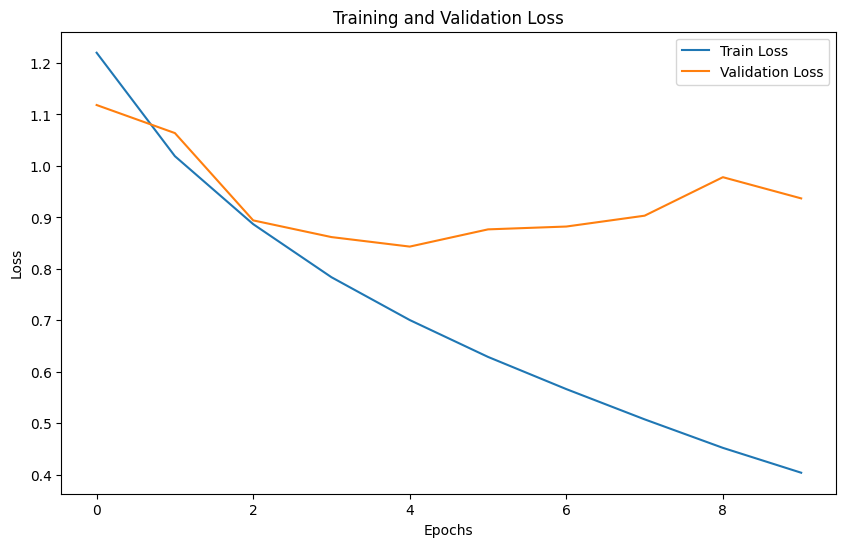

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [69]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [70]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.to(device)
loaded_model.eval()

<ipython-input-70-ef740e9073c3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [71]:
all_labels = []
all_preds = []
for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [72]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

       plane       0.75      0.76      0.75      1000
         car       0.84      0.84      0.84      1000
        bird       0.64      0.61      0.63      1000
         cat       0.53      0.58      0.55      1000
        deer       0.66      0.70      0.68      1000
         dog       0.71      0.49      0.58      1000
        frog       0.75      0.85      0.80      1000
       horse       0.73      0.78      0.75      1000
        ship       0.84      0.82      0.83      1000
       truck       0.80      0.79      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



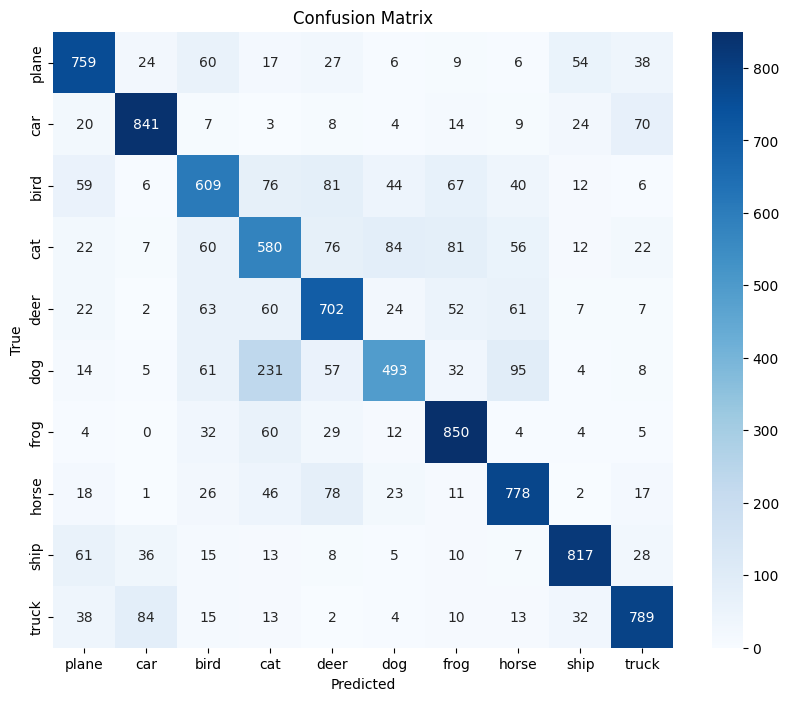

In [73]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()